In [2]:
# General
import numpy as np
import pandas as pd
import os

# For loading data and feature engineering
from feature_25 import MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt


In [2]:
# import importlib
# import feature_25 
# importlib.reload(feature_25)


In [3]:
# ============ 2) The Cross-Validation Function ============

def rolling_time_series_cv_sjm_long_short(
    lam,
    kappa,
    X,
    factor_returns,
    market_returns,
    n_splits=5,
    initial_train_size=5*252,
    val_size=252,
    cost_per_100pct=0.0005,
    annual_threshold=0.05
):
    """
    Your original rolling expanding-window CV function. For each fold, it clips/scales,
    fits a SparseJumpModel, does day-lag logic, and returns a single Sharpe.
    We then average across folds.
    """
    n_samples = len(X)
    max_folds = (n_samples - initial_train_size) // val_size
    actual_folds = min(n_splits, max_folds)

    max_feats = int(kappa**2)
    sharpe_scores = []

    def position_from_expected_return(ann_ret, threshold=annual_threshold):
        if ann_ret > threshold: 
            return 1.0
        elif ann_ret < -threshold: 
            return -1.0
        else: 
            return ann_ret / threshold

    start_of_val = initial_train_size

    for fold_i in range(actual_folds):
        train_end = start_of_val
        val_end = start_of_val + val_size
        if val_end > n_samples:
            val_end = n_samples

        # 1) Raw slices
        X_train_cv_raw = X.iloc[:train_end]
        y_train_cv     = factor_returns.iloc[:train_end]
        m_train_cv     = market_returns.iloc[:train_end]

        X_val_cv_raw   = X.iloc[train_end:val_end]
        y_val_cv       = factor_returns.iloc[train_end:val_end]
        m_val_cv       = market_returns.iloc[train_end:val_end]

        print(f"Fold {fold_i+1}: Train=[0:{train_end}], Val=[{train_end}:{val_end}]")

        # 2) Clipper/scaler on training portion only
        clipper_fold = DataClipperStd(mul=3.)
        X_train_cv_raw_clipped = clipper_fold.fit_transform(X_train_cv_raw)
        X_val_cv_raw_clipped   = clipper_fold.transform(X_val_cv_raw)

        scaler_fold = StandardScaler()
        X_train_cv = scaler_fold.fit_transform(X_train_cv_raw_clipped)
        X_val_cv   = scaler_fold.transform(X_val_cv_raw_clipped)

        # 3) Fit SJM
        model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats,
            jump_penalty=lam,
            cont=False,
            max_iter=30
        )
        model.fit(X_train_cv, y_train_cv, sort_by="cumret")

        # 4) Regime inference on validation
        val_states = model.predict_online(X_val_cv)

        # 5) Evaluate strategy: day-lag logic
        val_active_ret = y_val_cv - m_val_cv
        strategy_ret = np.zeros(len(val_states))
        prev_position = 0.0

        # Compute expected return per regime from training
        state_avg_daily_ret = model.ret_
        avg_mkt_ret = m_train_cv.mean()
        state_to_expected = {
            st: (state_avg_daily_ret[st] - avg_mkt_ret)*252
            for st in range(len(state_avg_daily_ret))
        }

        for t in range(len(val_states)):
            daily_pnl = prev_position * val_active_ret.iloc[t]
            st = val_states[t]
            new_position = position_from_expected_return(state_to_expected.get(st,0.0))
            turnover = abs(new_position - prev_position)*2.0
            cost = turnover * cost_per_100pct
            strategy_ret[t] = daily_pnl - cost
            prev_position = new_position

        avg_ret = np.mean(strategy_ret)
        std_ret = np.std(strategy_ret, ddof=1)
        val_sharpe = 0.0 if std_ret==0 else (avg_ret/std_ret)*np.sqrt(252)

        sharpe_scores.append(val_sharpe)
        start_of_val += val_size  # expand window for next fold

    return np.mean(sharpe_scores)


Running SJM cross-validation for factor = IWF
Training starts: 2002-08-28 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-02-24 00:00:00
[IWF] Best Jump Penalty (λ): 66.17434558908558
[IWF] Best Max Features (κ²): 4
[IWF] Sharpe with best hyperparams: 0.26554761785687564


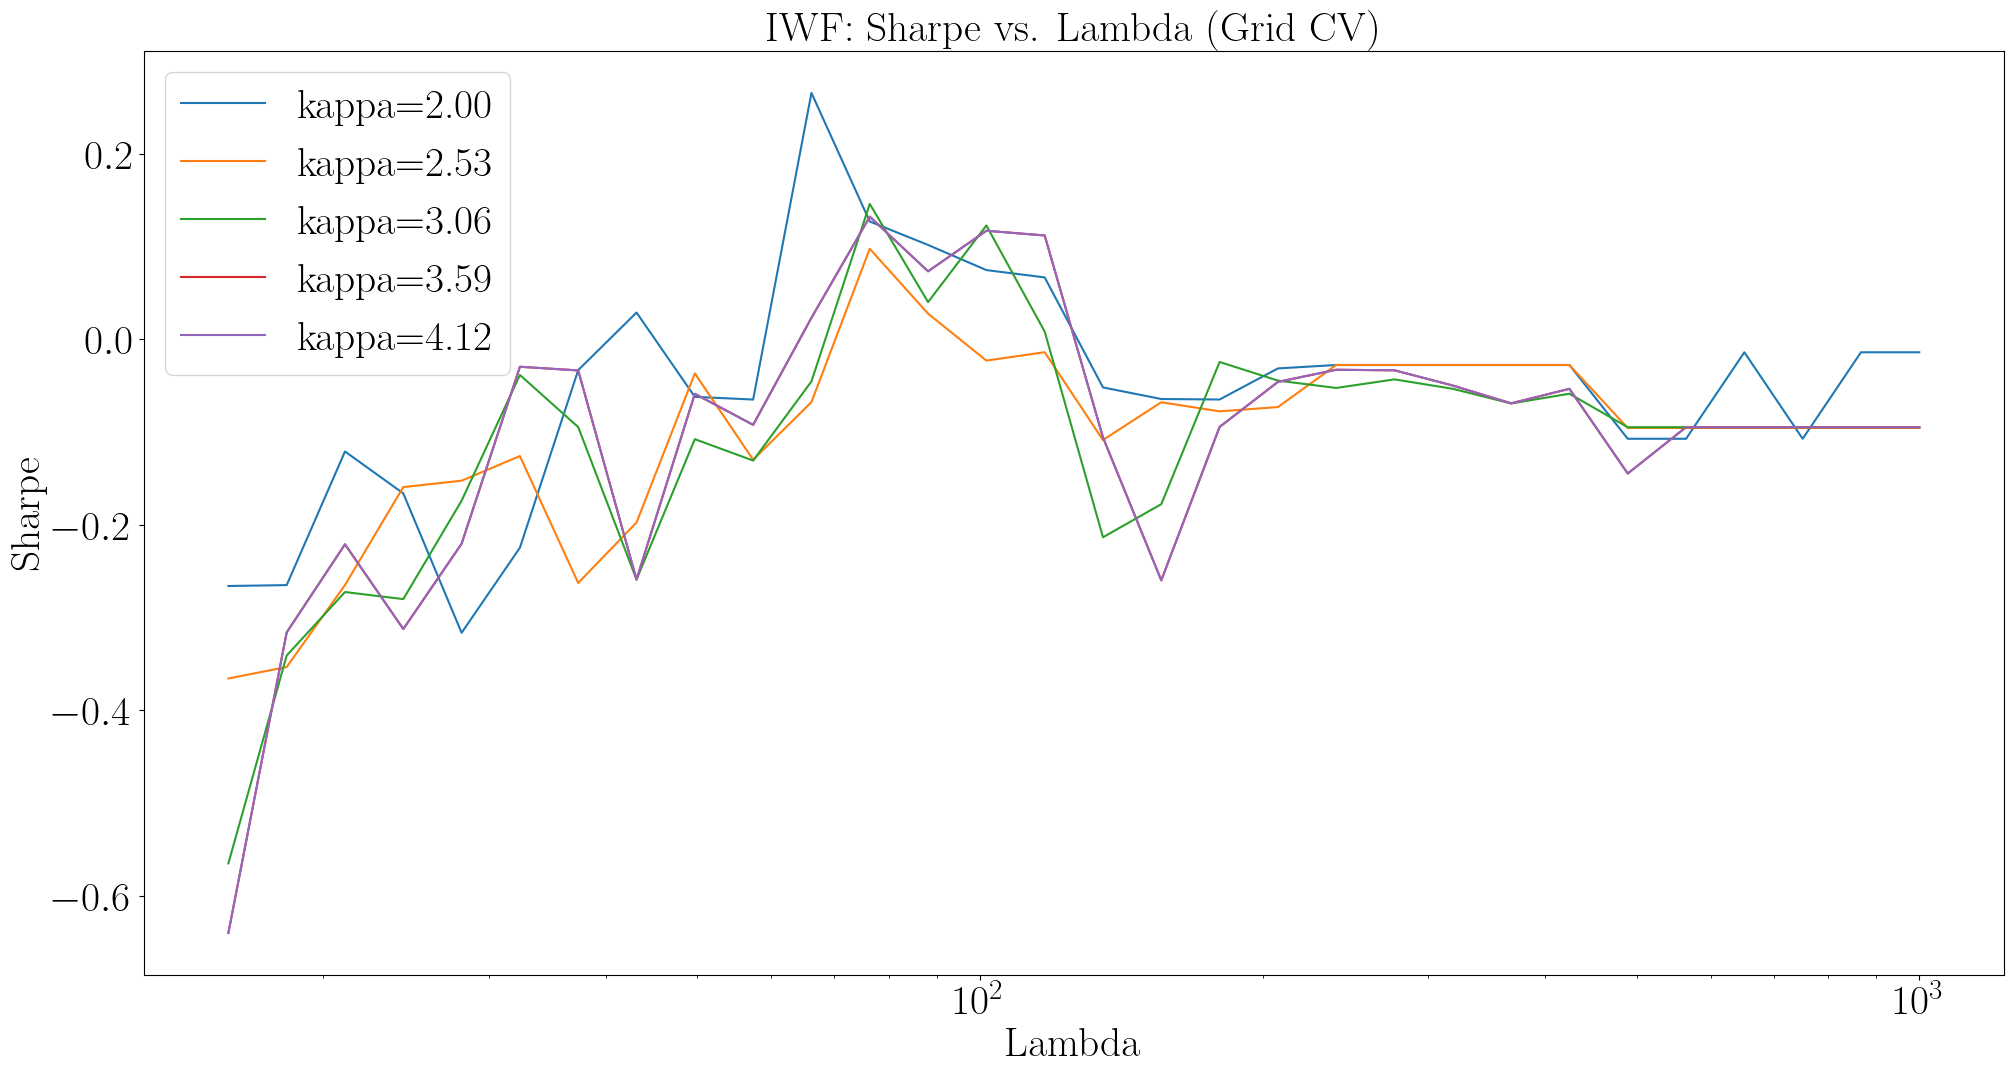

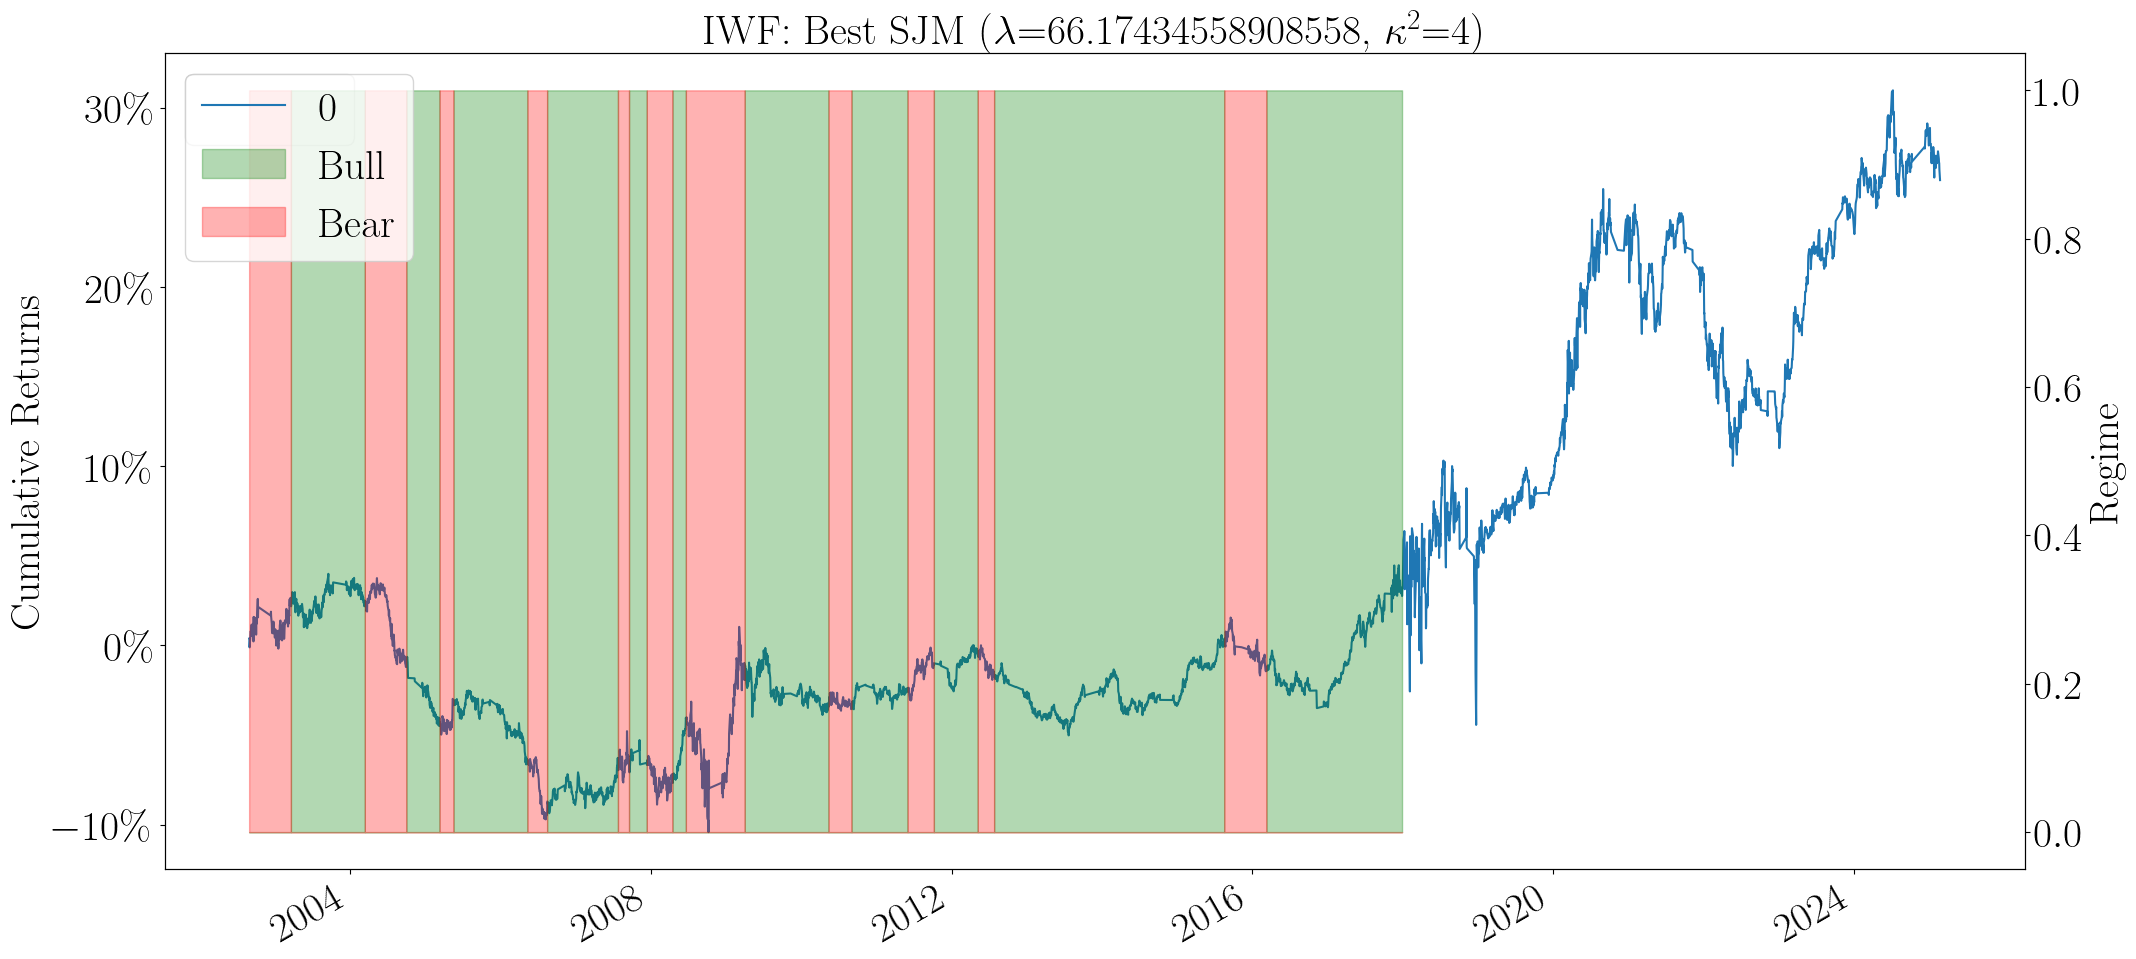


Running SJM cross-validation for factor = MTUM
Training starts: 2002-08-28 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-02-24 00:00:00
[MTUM] Best Jump Penalty (λ): 239.5026619987486
[MTUM] Best Max Features (κ²): 4
[MTUM] Sharpe with best hyperparams: 0.5651212740657675


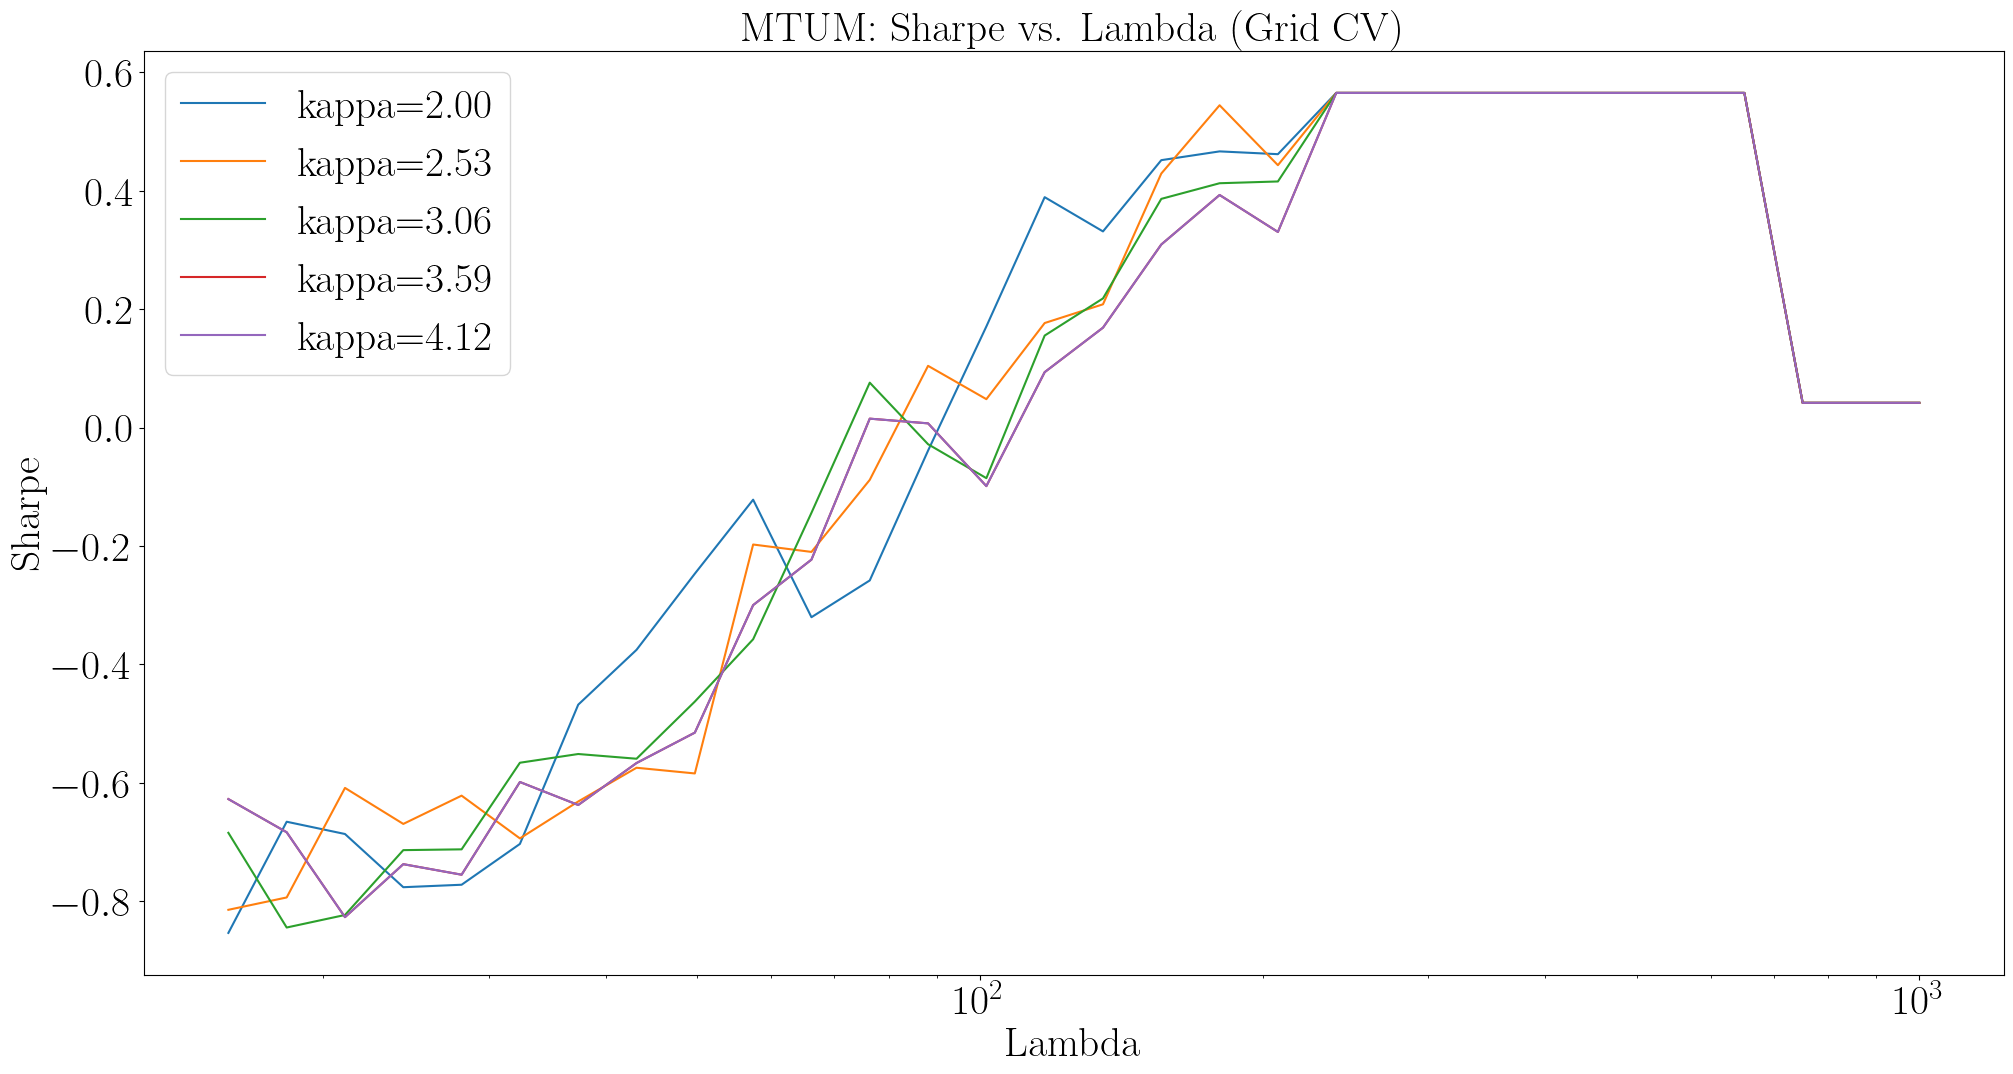

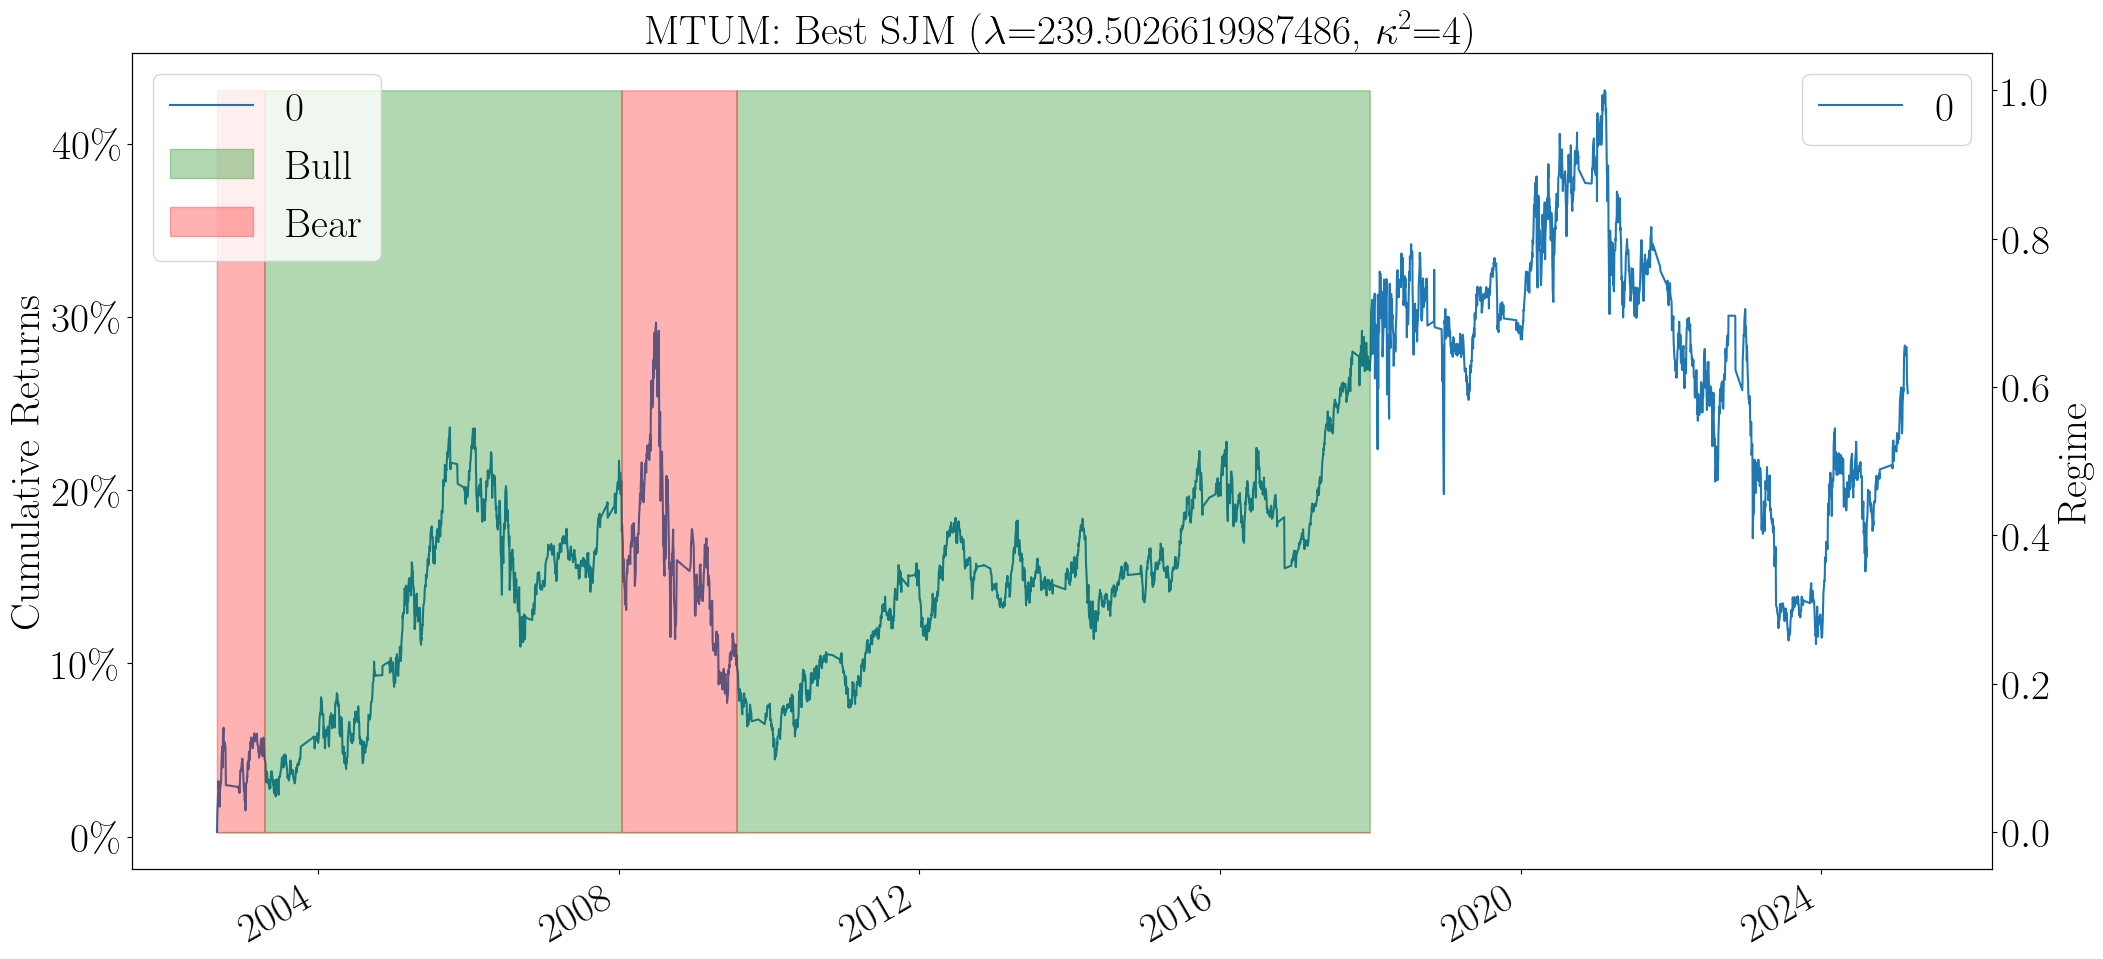


Running SJM cross-validation for factor = QUAL
Training starts: 2002-08-28 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-02-24 00:00:00
[QUAL] Best Jump Penalty (λ): 66.17434558908558
[QUAL] Best Max Features (κ²): 6
[QUAL] Sharpe with best hyperparams: 0.25383859429267075


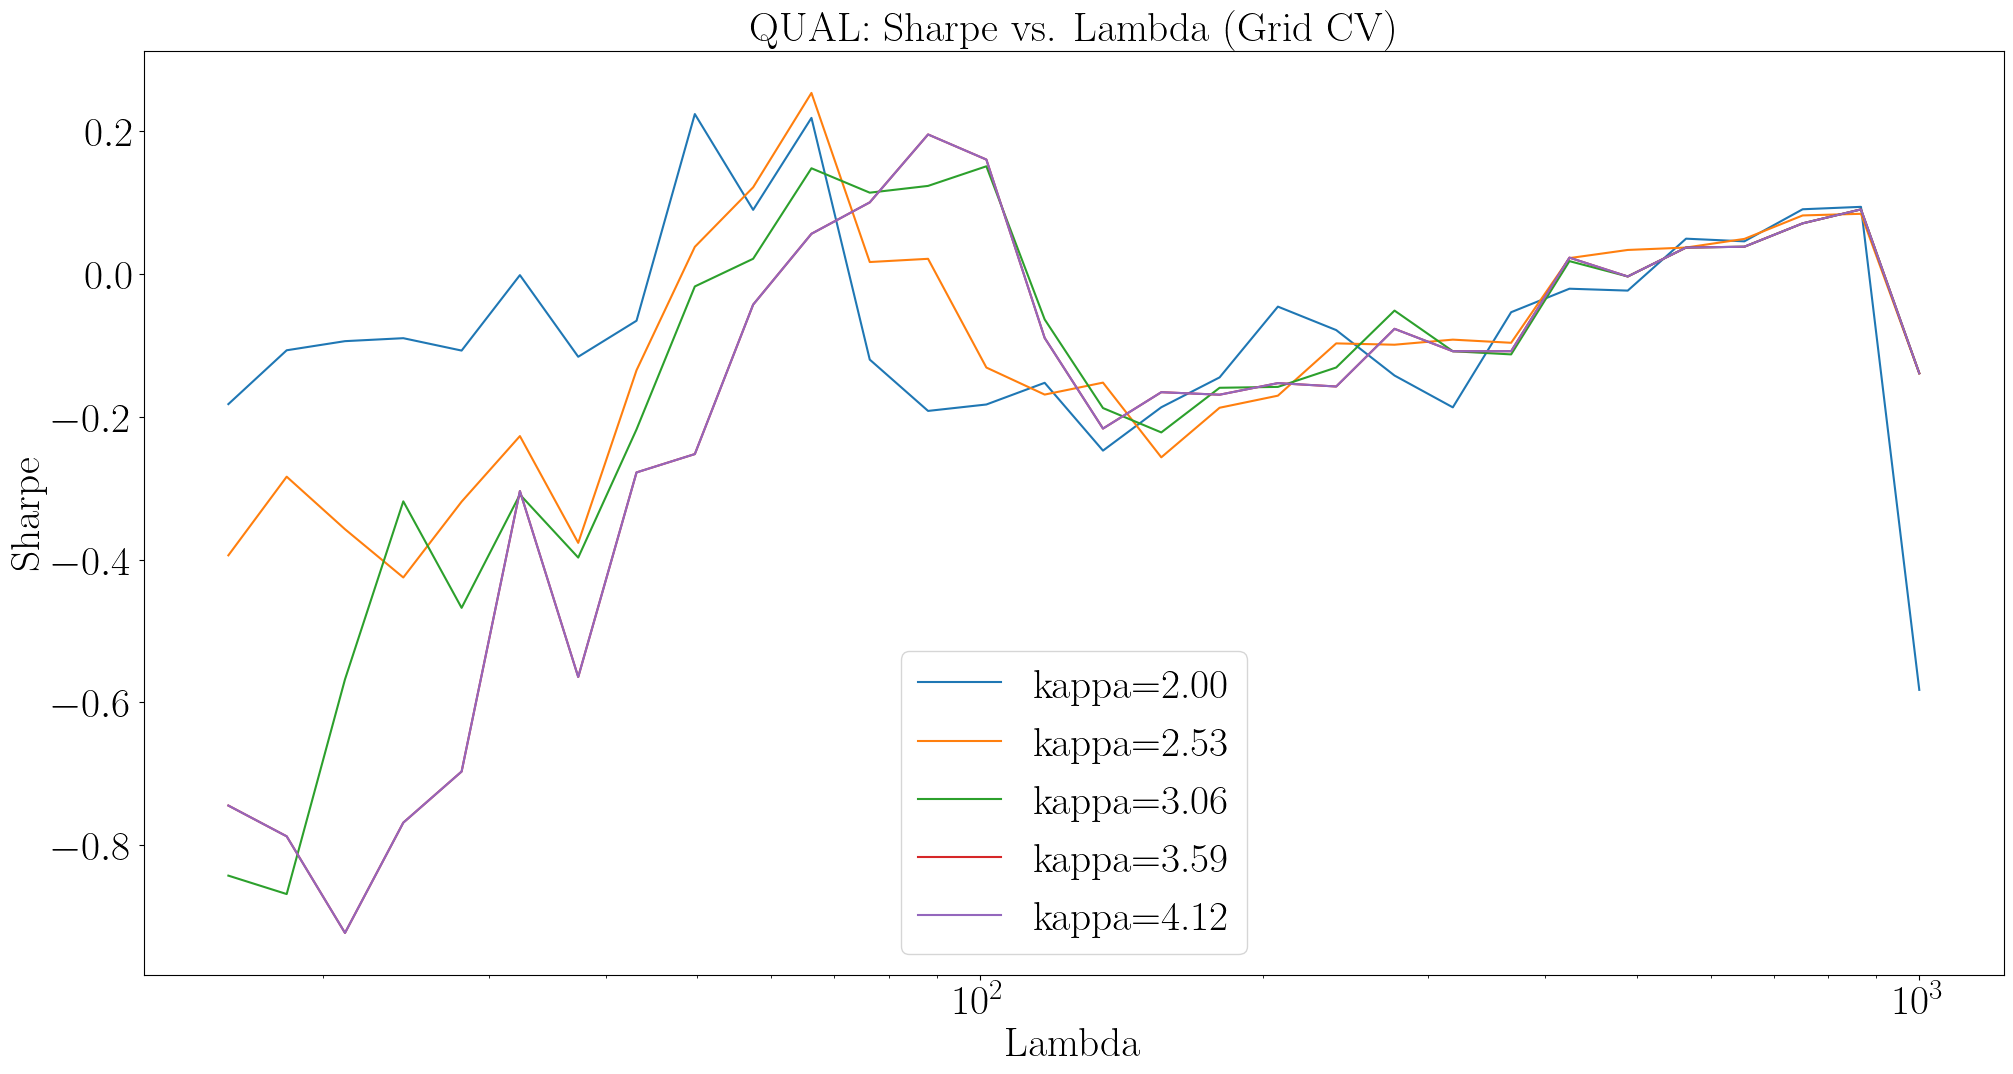

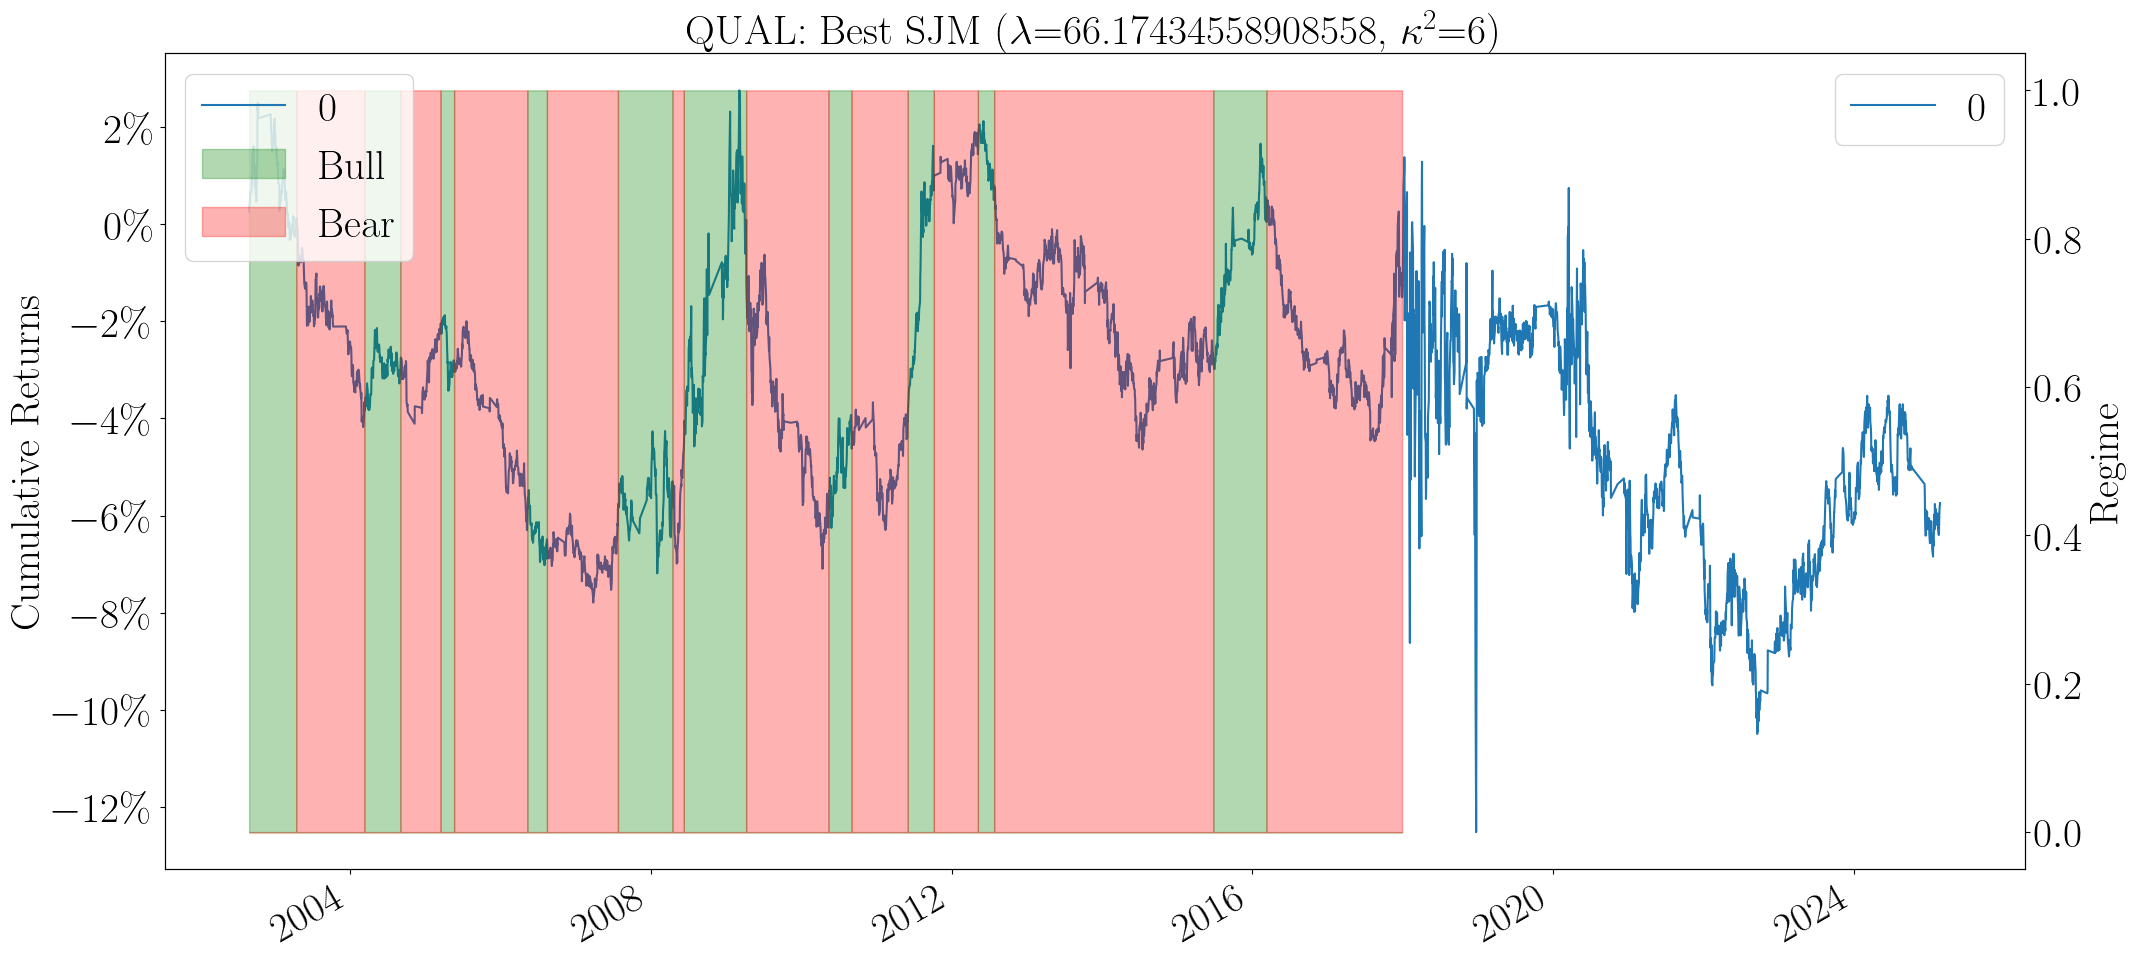


Running SJM cross-validation for factor = SIZE
Training starts: 2002-08-28 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-03 00:00:00 ends: 2025-02-24 00:00:00
[SIZE] Best Jump Penalty (λ): 49.72235891449993
[SIZE] Best Max Features (κ²): 12
[SIZE] Sharpe with best hyperparams: 0.583180977807284


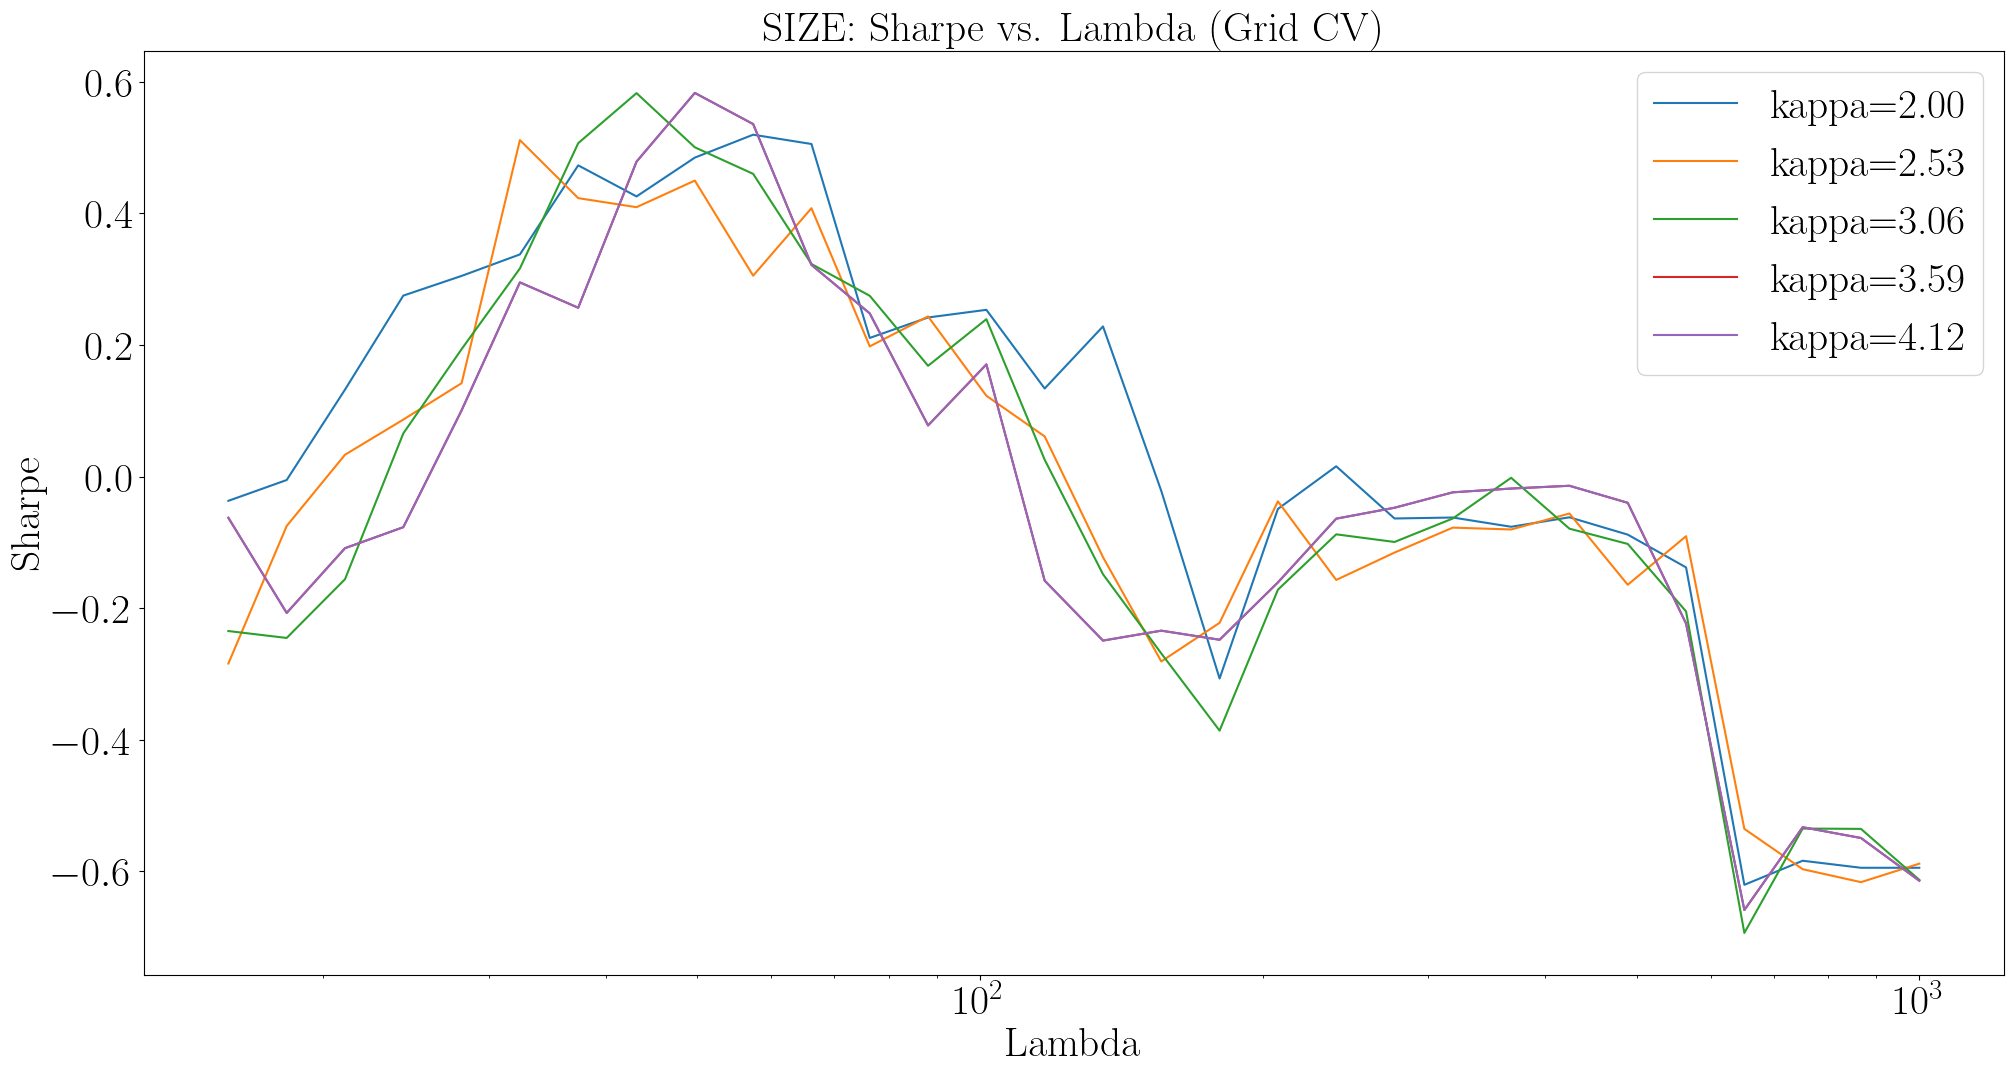

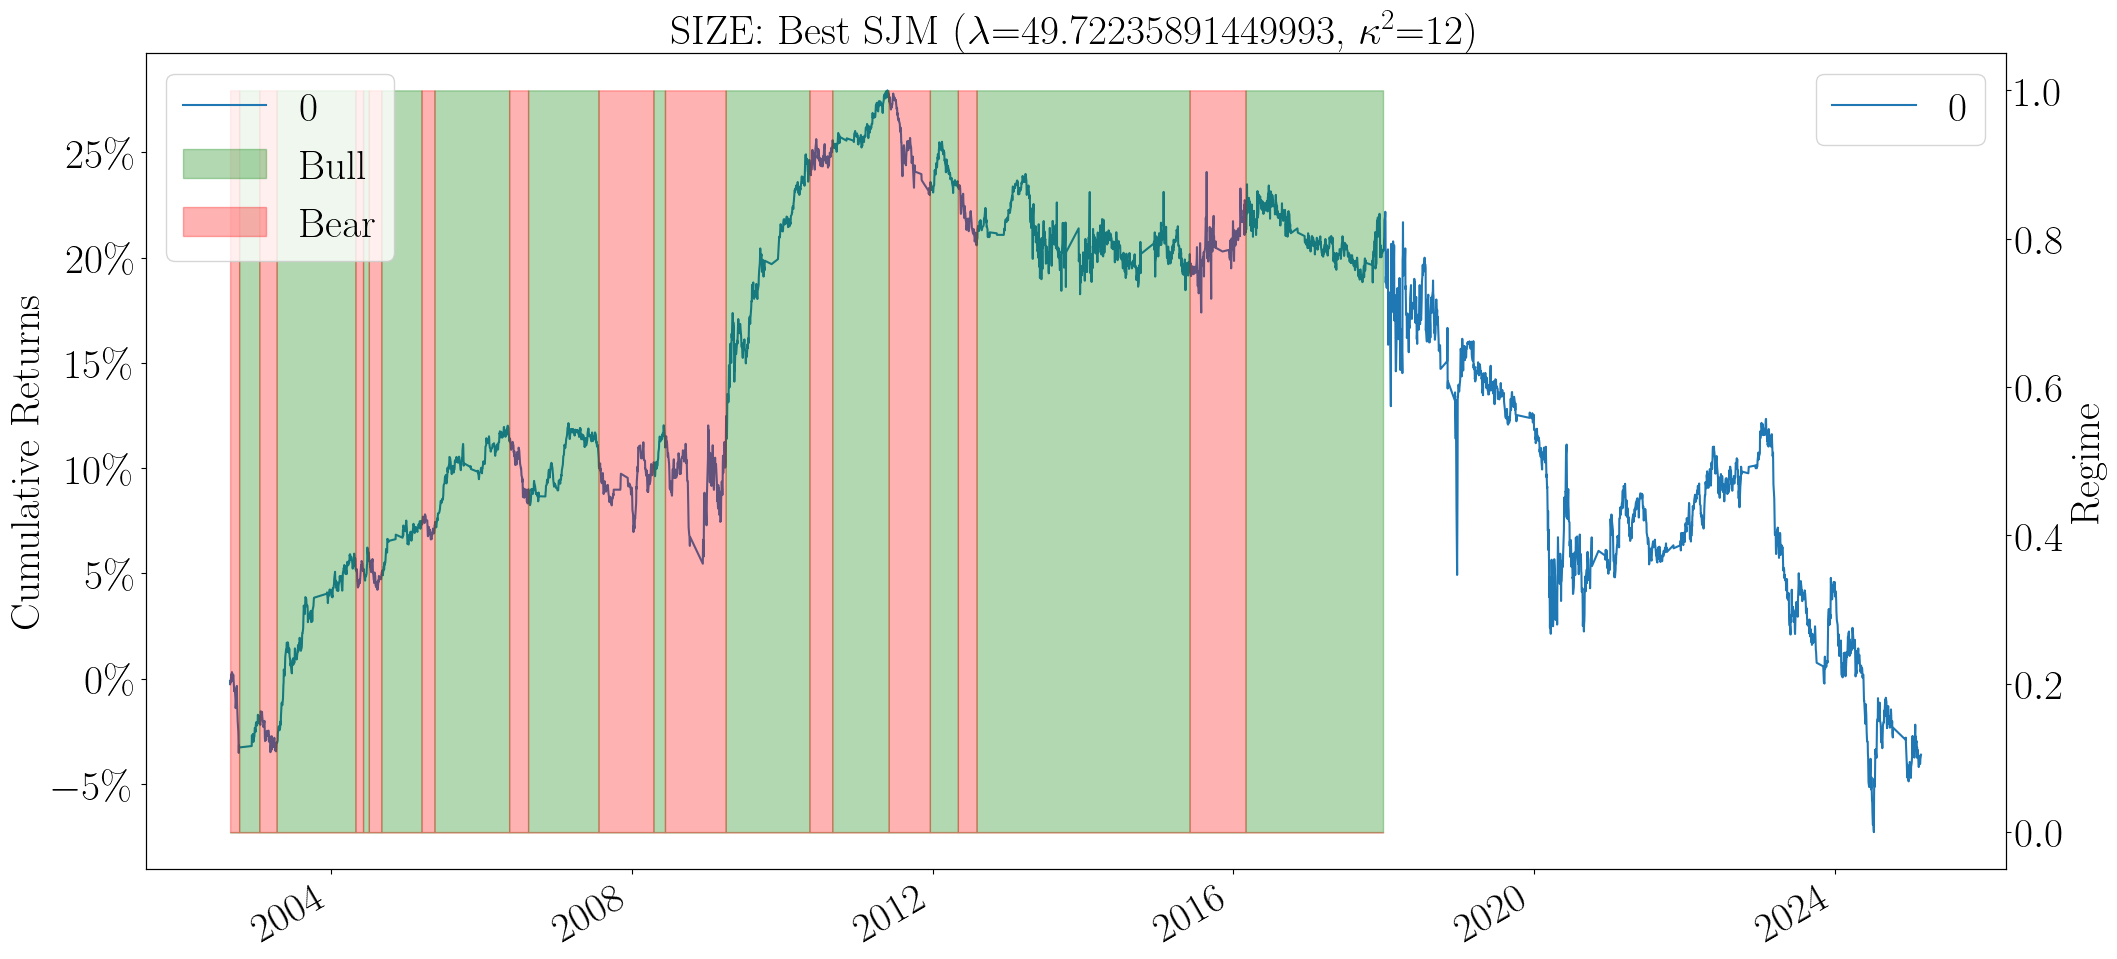


Running SJM cross-validation for factor = USMV
Training starts: 2002-08-28 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-02-24 00:00:00
[USMV] Best Jump Penalty (λ): 751.3842180360134
[USMV] Best Max Features (κ²): 6
[USMV] Sharpe with best hyperparams: 0.17376469442761117


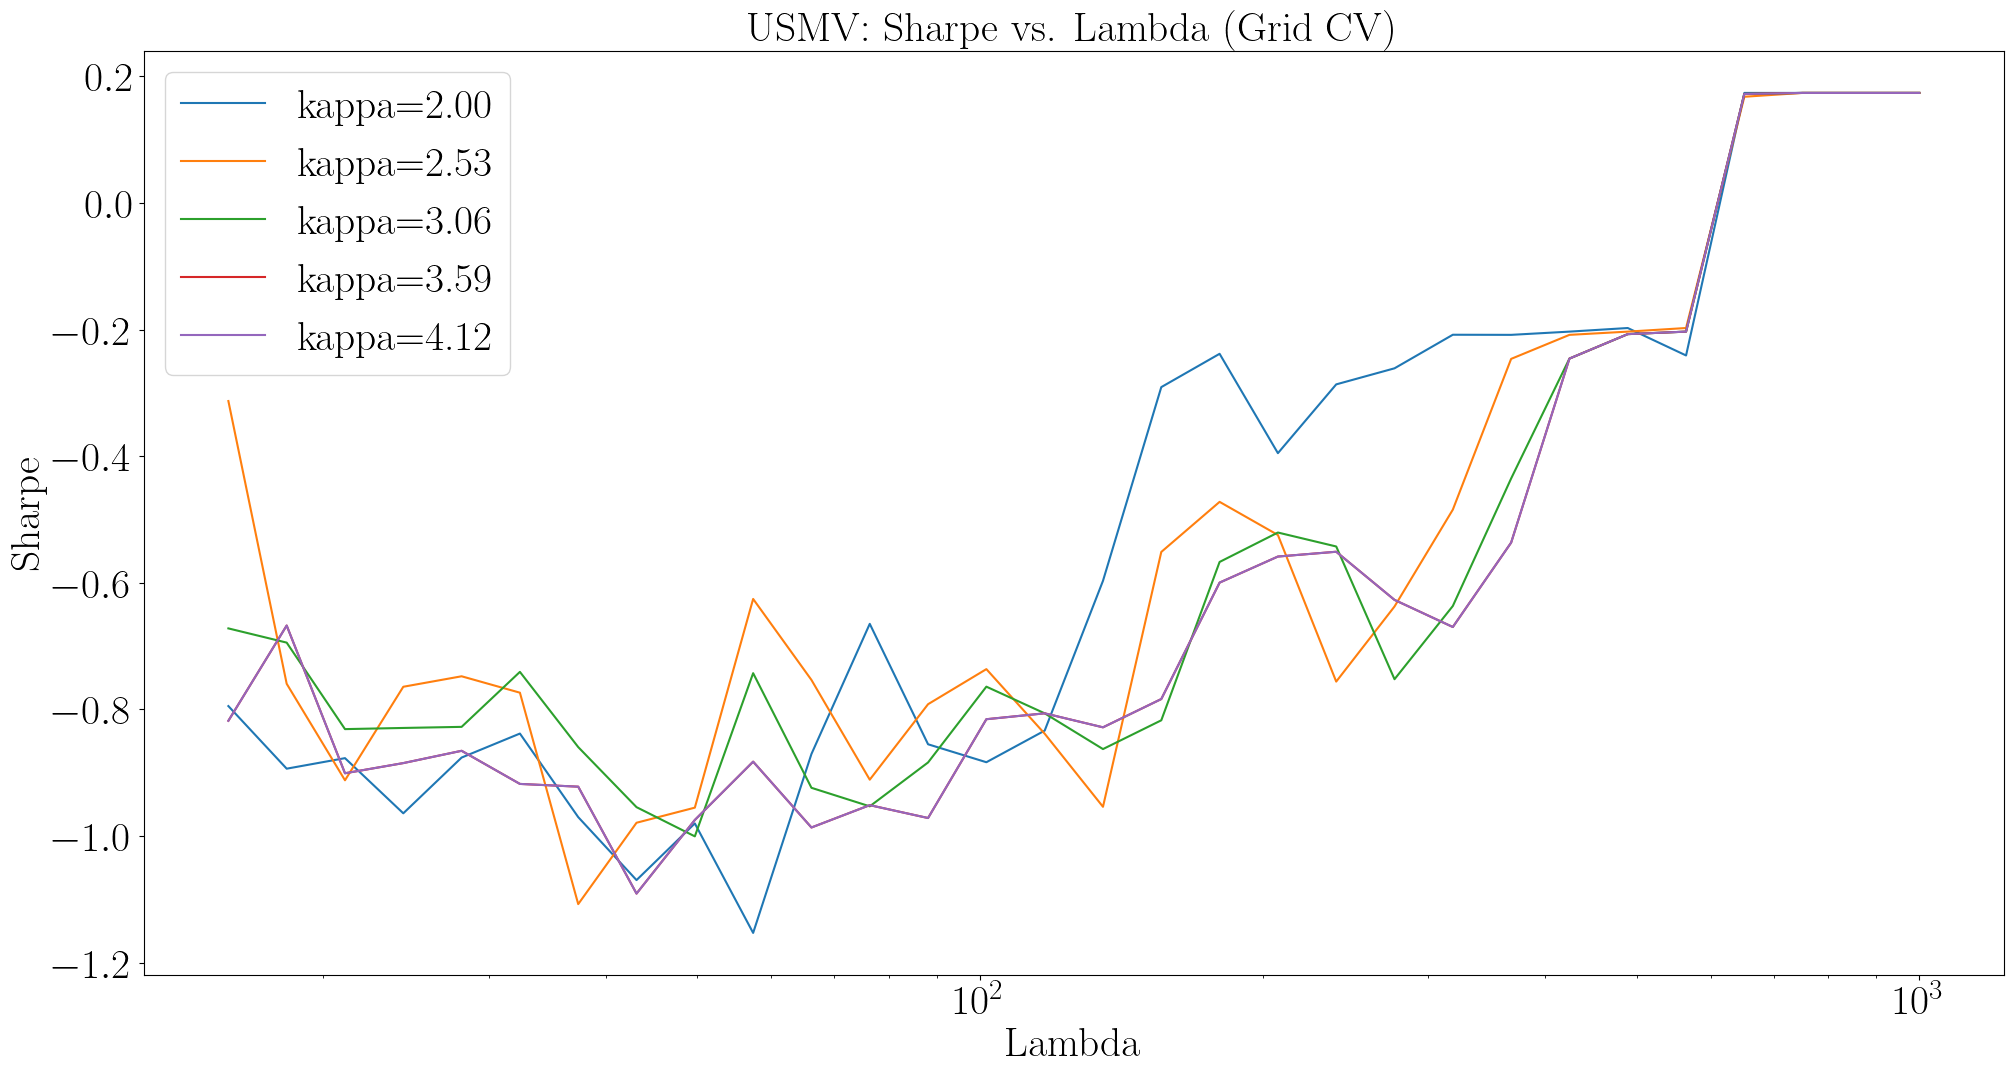

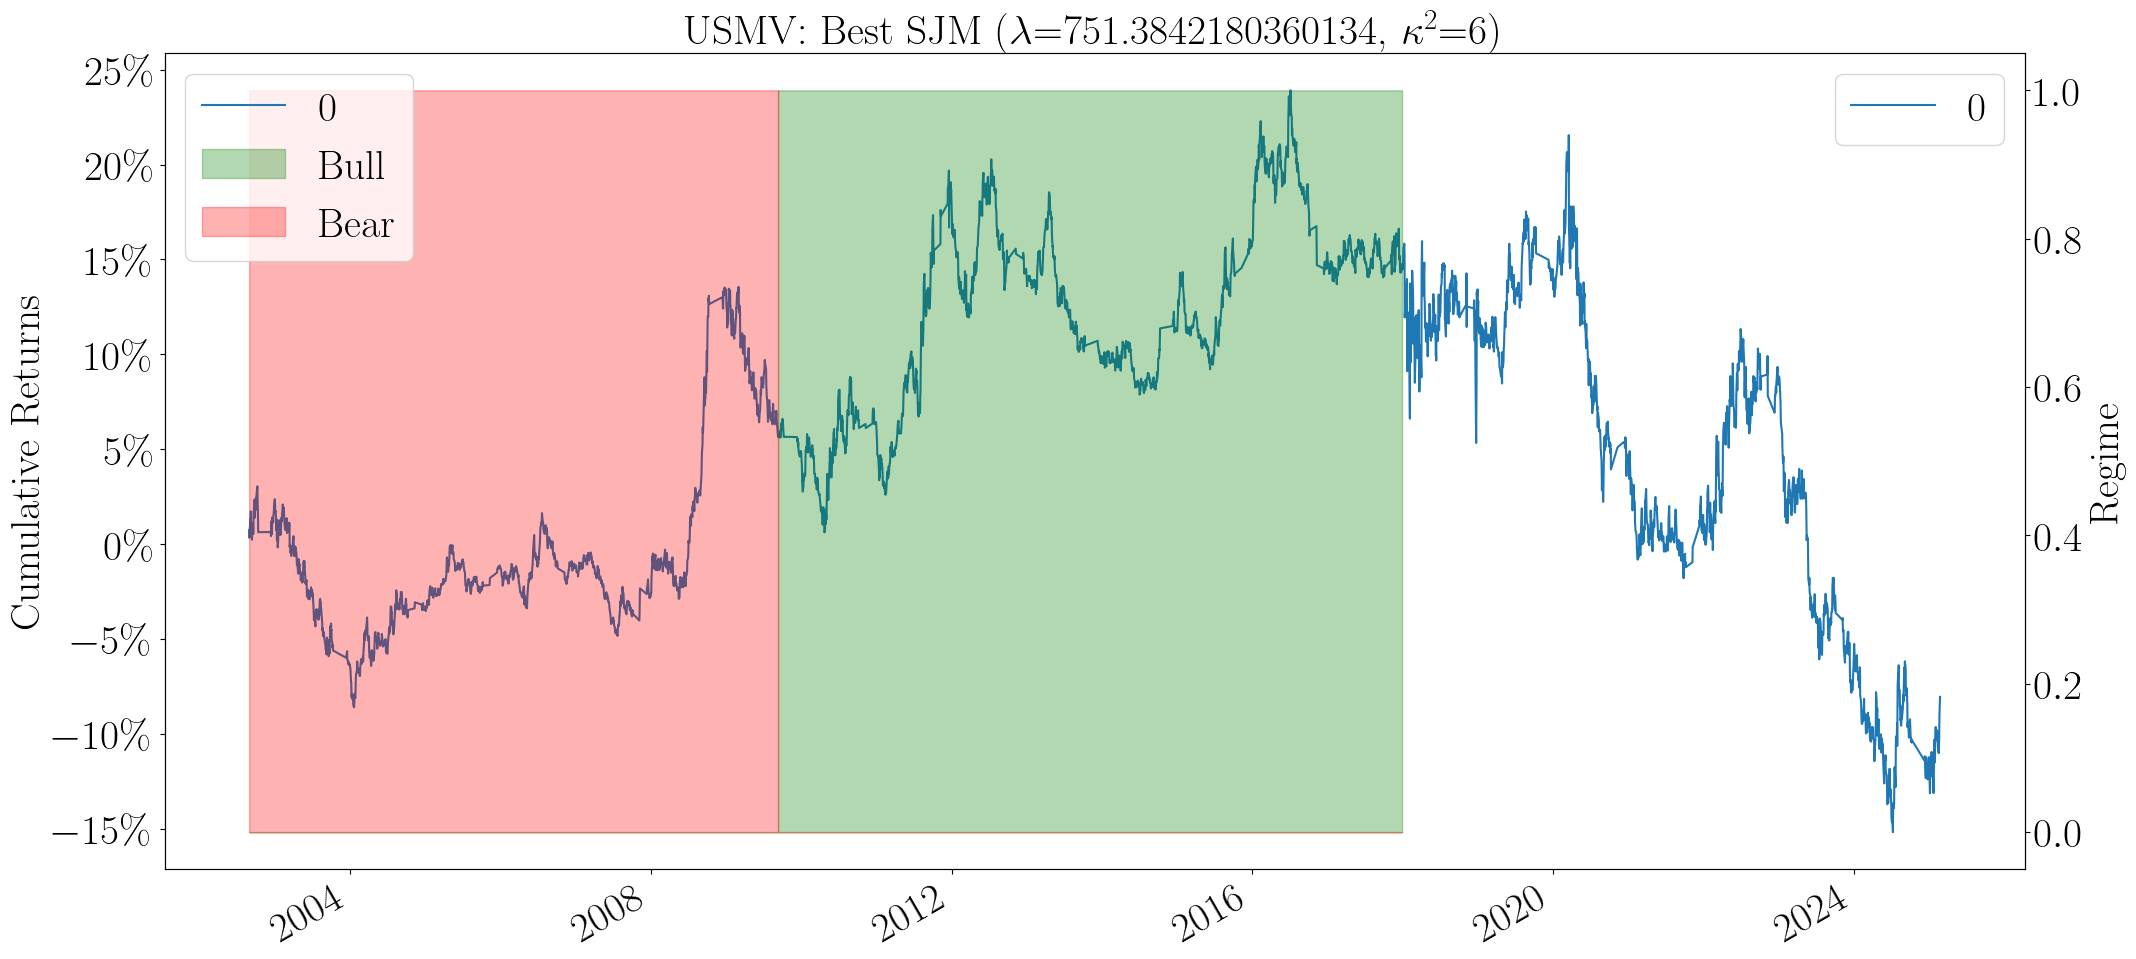


Running SJM cross-validation for factor = VLUE
Training starts: 2002-08-28 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-02-24 00:00:00
[VLUE] Best Jump Penalty (λ): 57.36152510448679
[VLUE] Best Max Features (κ²): 4
[VLUE] Sharpe with best hyperparams: 1.390909270041218


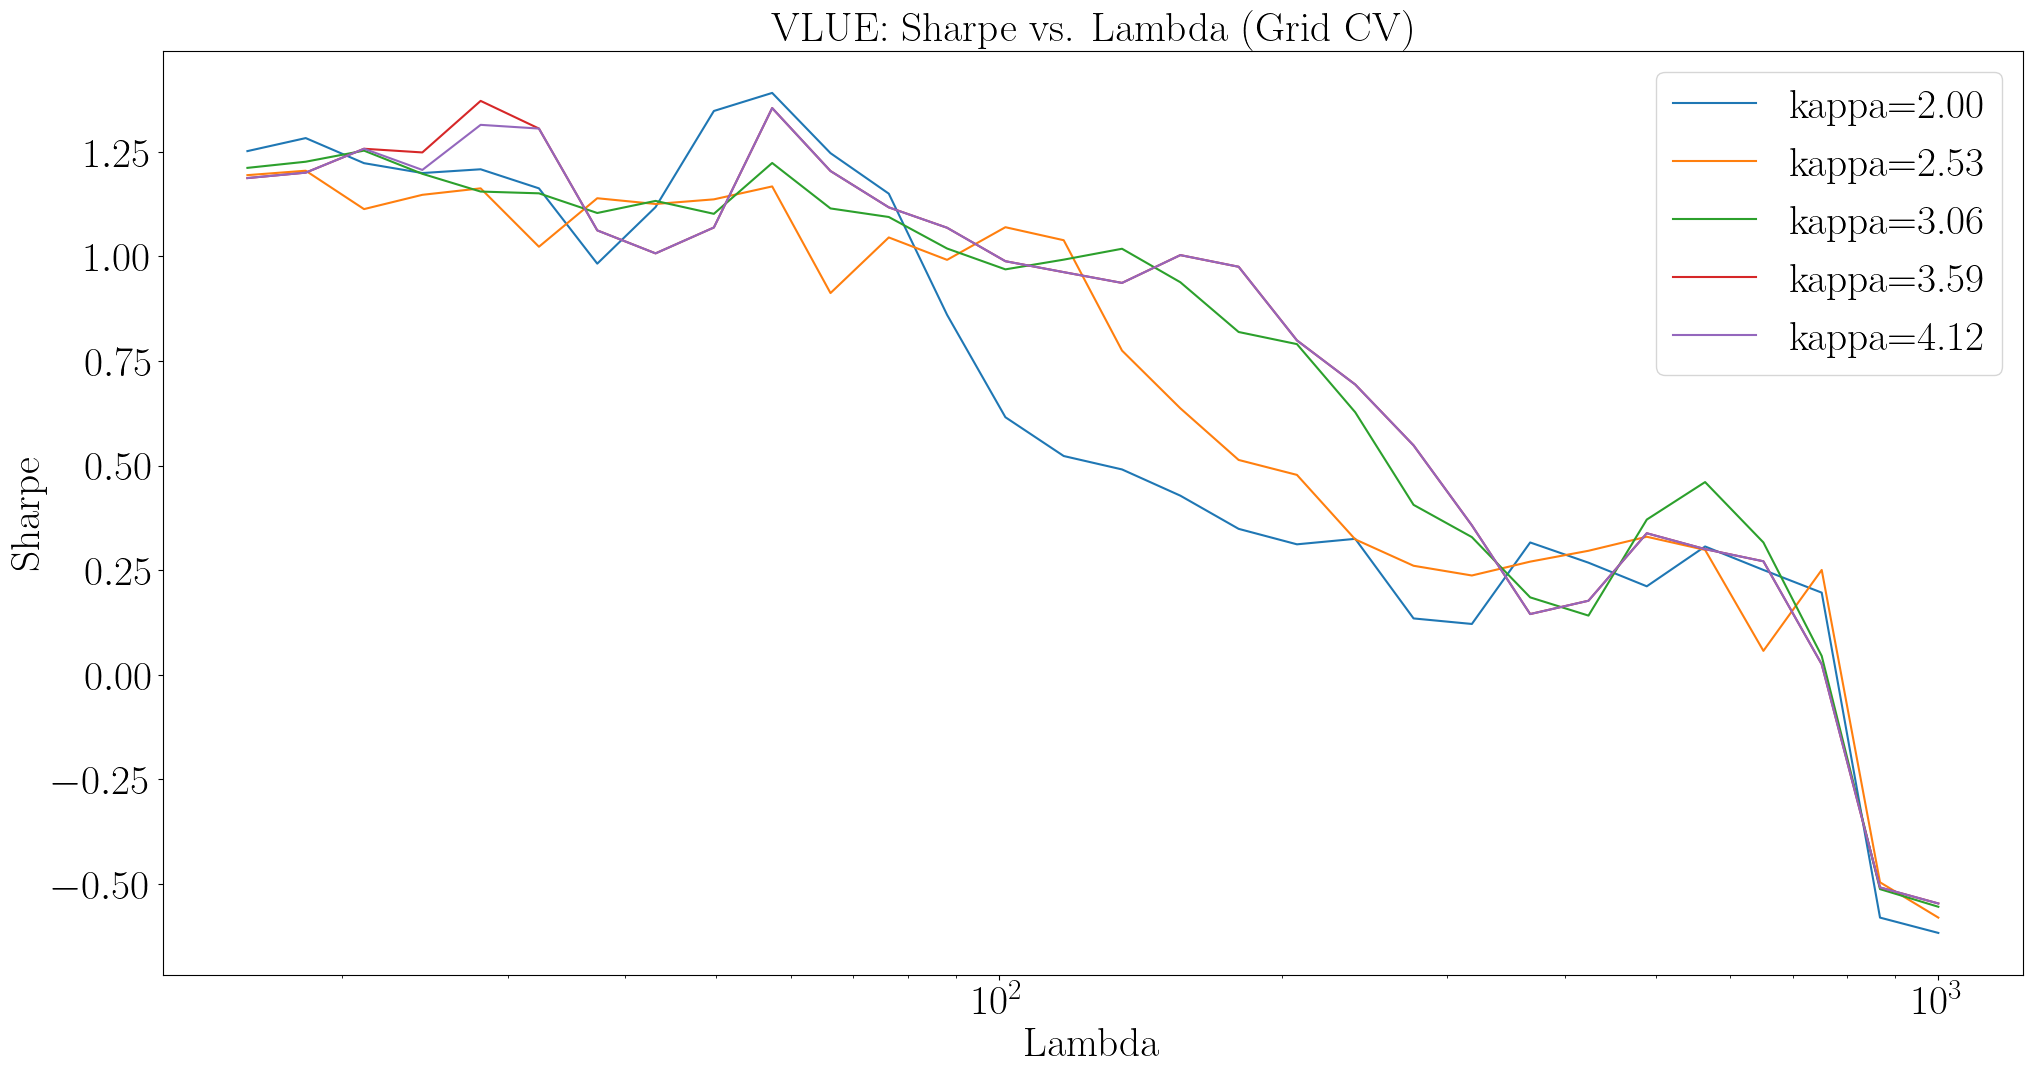

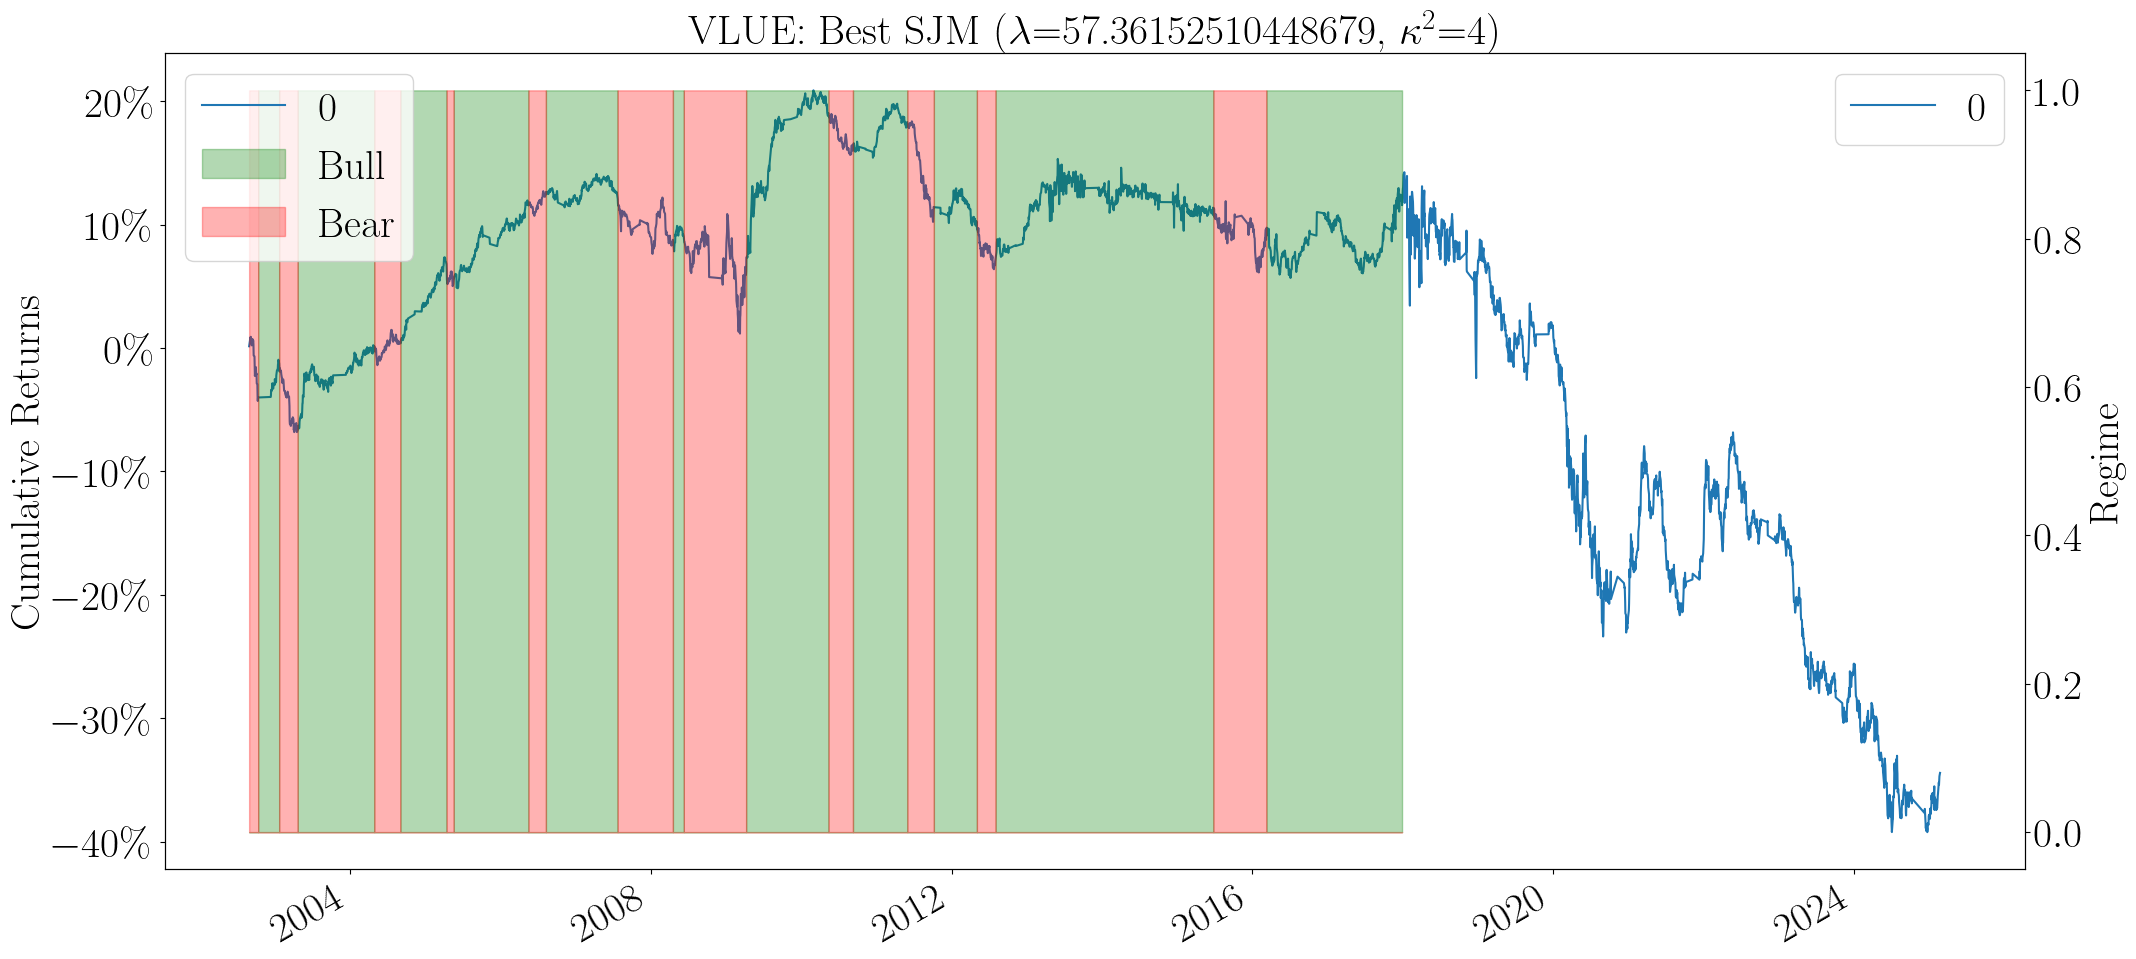


All factors finished.


In [ ]:
if __name__ == "__main__":
    directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
    factor_file = os.path.join(directory, "factor_data.csv")
    market_file = os.path.join(directory, "market_data.csv")

    # We'll run for these factors:
    all_factors = ["IWF", "MTUM", "QUAL", "SIZE", "USMV", "VLUE"]

    # Dictionary to store best hyperparameters for each factor
    best_hyperparams = {}

    for factor_name in all_factors:
        print("\n==============================================================")
        print(f"Running SJM cross-validation for factor = {factor_name}")
        print("==============================================================")

        # 1) Load data
        data = MergedDataLoader(
            factor_file=factor_file,
            market_file=market_file,
            ver="v2",
            factor_col=factor_name
        ).load(start_date="2002-05-31", end_date="2025-02-24")

        # Ensure alignment
        common_index = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
        data.X = data.X.loc[common_index]
        data.ret_ser = data.ret_ser.loc[common_index]
        data.market_ser = data.market_ser.loc[common_index]

        # Drop zero-return dates
        zero_return_dates = data.ret_ser[data.ret_ser == 0.0].index
        data.X = data.X.drop(zero_return_dates, errors='ignore')
        data.ret_ser = data.ret_ser.drop(zero_return_dates, errors='ignore')
        data.market_ser = data.market_ser.drop(zero_return_dates, errors='ignore')

        # 2) Train/test split
        train_start, test_start = "2002-05-31", "2018-01-01"
        X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
        X_test  = filter_date_range(data.X, start_date=test_start)

        # For reference
        tr_start_idx, tr_end_idx = X_train.index[[0, -1]]
        print("Training starts:", tr_start_idx, "ends:", tr_end_idx)
        if len(X_test) > 0:
            te_start_idx, te_end_idx = X_test.index[[0, -1]]
            print("Testing starts:", te_start_idx, "ends:", te_end_idx)
        else:
            print("No test data after:", test_start)

        # 3) Preprocessing for final model
        clipper = DataClipperStd(mul=3.)
        scalar_pd = StandardScalerPD()
        X_train_processed = scalar_pd.fit_transform(clipper.fit_transform(X_train))
        if len(X_test) > 0:
            X_test_processed  = scalar_pd.transform(clipper.transform(X_test))
        else:
            X_test_processed = None

        # 4) Define hyperparameter grids
        lambda_values = np.logspace(1.2, 3, 30)
        kappa_values  = np.linspace(2, np.sqrt(X_train.shape[1]), 5)

        # 5) Parallel cross-validation
        from joblib import Parallel, delayed
        market_ser = data.market_ser
        results = Parallel(n_jobs=4)(
            delayed(rolling_time_series_cv_sjm_long_short)(
                lam, kappa, 
                X_train,
                factor_returns=data.ret_ser,
                market_returns=market_ser
            )
            for lam in lambda_values
            for kappa in kappa_values
        )

        # 6) Identify best param
        results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))
        best_index = np.argmax(results)
        best_lambda = lambda_values[best_index // len(kappa_values)]
        best_kappa  = kappa_values[best_index % len(kappa_values)]
        max_feats_best = int(best_kappa**2)
        best_sharpe = results[best_index]

        print(f"[{factor_name}] Best Jump Penalty (λ): {best_lambda}")
        print(f"[{factor_name}] Best Max Features (κ²): {max_feats_best}")
        print(f"[{factor_name}] Sharpe with best hyperparams: {best_sharpe}")

        # Store best hyperparameters for this factor
        best_hyperparams[factor_name] = {
            "best_lambda": best_lambda,
            "best_kappa": best_kappa
        }

        # 7) Plot Sharpe vs. Lambda for each kappa
        plt.figure()
        for i, kp in enumerate(kappa_values):
            plt.plot(lambda_values, results_array[:, i], label=f"kappa={kp:.2f}")
        plt.xscale('log')
        plt.xlabel('Lambda')
        plt.ylabel('Sharpe')
        plt.title(f"{factor_name}: Sharpe vs. Lambda (Grid CV)")
        plt.legend()
        plt.show()

        # 8) Fit final model on entire training set, predict states, plot in-sample regimes
        final_model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats_best,
            jump_penalty=best_lambda,
            cont=False,
            max_iter=30
        )
        final_model.fit(X_train_processed, data.active_ret, sort_by="cumret")
        predicted_states = final_model.predict(X_train_processed)

        ax, ax2 = plot_regimes_and_cumret(predicted_states, data.active_ret)
        ax.set(title=f"{factor_name}: Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
        plt.show()

    print("\nAll factors finished.")



In [7]:
# ============ 3) The EWMA Covariance Function ============

def ewm_covariance(returns: pd.DataFrame, halflife=126, min_periods=1) -> pd.DataFrame:
    """
    Compute a single EWMA-based covariance matrix over 'returns' DataFrame,
    using half-life = 126 days. 
    """
    # returns.shape = (T, N), with T daily rows, N assets
    # The .ewm(...).cov() call yields a multi-index result of shape (T*N, N).
    # We pick the LAST row to get the final cov over the entire 'returns'.

    ewm_cov = returns.ewm(
        halflife=halflife, 
        adjust=False, 
        min_periods=min_periods
    ).cov()  # multi-index: (date, column), column2 -> cov

    # The last chunk for that multi-index is the NxN covariance
    # corresponding to the last date in 'returns.index'
    last_date = returns.index[-1]
    df_slice = ewm_cov.loc[last_date]  # shape (N, N) = final day’s covariance
    df_slice.index.name = None
    return df_slice


In [12]:
def run_bl_portfolio_pyopt_rolling_expanding(
    factor_dict,
    returns_df,
    test_index,        # e.g. the test (out-of-sample) dates
    tau=0.05,
    delta=2.5
):
    """
    Uses an *expanding* window for covariance estimation (exponential decay)
    and applies a 1-day lag for rebalancing.
    """
    assets = list(returns_df.columns)   # e.g. [factor1, factor2, ..., Market]
    factors = list(factor_dict.keys())  # e.g. [factor1, factor2, ...]
    weights_df = pd.DataFrame(index=test_index, columns=assets, dtype=float)

    # We'll store the "day t" computed weights into row "t+1"
    # to enforce a one-day lag in actual portfolio rebalancing.
    test_dates = list(test_index)

    for i, t in enumerate(test_dates):
        # 1) Use *all* data up to day (t-1).
        #    If t is the very first date, the slice might be empty,
        #    so you may want to skip or handle that edge case.
        window_end_idx = returns_df.index.get_loc(t)
        if window_end_idx == 0:
            # Edge case: no prior data. You could skip or do something trivial.
            continue
        # Expanding slice from start (index 0) up to (but not including) t
        expanding_slice = returns_df.iloc[:window_end_idx]

        # 2) Compute EWMA covariance on the entire expanding slice
        #    with half-life = 126 days
        cov_matrix = ewm_covariance(expanding_slice, halflife=126, min_periods=60)

        # 3) Build (P, Q) from factor states on day t
        Q_values = []
        P_matrix = []
        for fac in factors:
            st = factor_dict[fac]['states'].loc[t]
            # daily avg active ret for that factor's regime
            daily_active_ret = factor_dict[fac]['regime_returns'][st]
            annual_active_ret = daily_active_ret * 252
            Q_values.append(annual_active_ret)
            # each row in P is +1 for that factor, -1 for 'Market'
            row = [0]*len(assets)
            row[assets.index(fac)] = 1
            row[assets.index('Market')] = -1
            P_matrix.append(row)

        P = pd.DataFrame(P_matrix, columns=assets)
        Q = pd.Series(Q_values)

        # 4) Build Black-Litterman
        bl = BlackLittermanModel(
            cov_matrix=cov_matrix,
            pi=None,   # or pi=delta * cov_matrix @ [some market weights]
            P=P,
            Q=Q,
            tau=tau,
            omega="diagonal"
        )

        mu_bl = bl.bl_returns()

        # 5) Mean-variance optimization
        ef = EfficientFrontier(mu_bl, cov_matrix, weight_bounds=(0,1))
        ef.add_constraint(lambda w: np.sum(w) == 1)
        ef.max_sharpe()  # or ef.min_volatility(), ef.efficient_risk(), etc.

        w_series = pd.Series(ef.clean_weights(), name=t)

        # 6) Store weights for day (t+1)
        if i < len(test_dates) - 1:
            rebalance_day = test_dates[i+1]
            weights_df.loc[rebalance_day] = w_series
        else:
            # Last date in the loop
            weights_df.loc[t] = w_series

    return weights_df


In [13]:
# manual build of best_hyperparams dict for BL model if we don't want to run the SJM CV again
best_hyperparams = {
    "IWF": {
        "best_lambda": 66.17434558908558,
        "best_kappa": 2.0
    },
    "MTUM": {
        "best_lambda": 239.5026619987486,
        "best_kappa": 2.0
    },
    "QUAL": {
        "best_lambda": 66.17434558908558,
        "best_kappa": 2.44948974278
    },
    "SIZE": {
        "best_lambda": 49.72235891449993,
        "best_kappa": 3.46410161514
    },
    "USMV": {
        "best_lambda": 751.3842180360134,
        "best_kappa": 2.44948974278
    },
    "VLUE": {
        "best_lambda": 57.36152510448679,
        "best_kappa": 2
    },
}


In [14]:
# 1) Set up file paths, factor list, etc.
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
factor_file = os.path.join(directory, "factor_data.csv")
market_file = os.path.join(directory, "market_data.csv")

factors = ["IWF", "MTUM", "QUAL", "SIZE", "USMV", "VLUE"]
train_start, test_start = "2002-05-31", "2018-01-01"

# 2) Build dictionary with final SJM results, plus factor + market test returns
factor_dict = {}
for fac in factors:
    # --Load + align data--
    data = MergedDataLoader(
        factor_file=factor_file,
        market_file=market_file,
        ver="v2",
        factor_col=fac
    ).load()
    common_idx = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
    X = data.X.loc[common_idx]
    fac_ret = data.ret_ser.loc[common_idx]  # absolute factor returns
    mkt_ret = data.market_ser.loc[common_idx]
    active_ret = fac_ret - mkt_ret         # factor minus market

    # --Train/test splits--
    X_train = filter_date_range(X, start_date=train_start, end_date=test_start)
    X_test  = filter_date_range(X, start_date=test_start)
    active_ret_train = filter_date_range(active_ret, start_date=train_start, end_date=test_start)
    active_ret_test  = filter_date_range(active_ret, start_date=test_start)

    fac_ret_test = filter_date_range(fac_ret, start_date=test_start)  # For final portfolio
    mkt_ret_test = filter_date_range(mkt_ret, start_date=test_start)

    # --Scale & clip training features--
    clipper = DataClipperStd(mul=3.0)
    scaler = StandardScalerPD()
    X_train_proc = scaler.fit_transform(clipper.fit_transform(X_train))

    # --Online scaling for X_test to avoid lookahead--
    X_test_proc_list = []
    for i in range(len(X_test)):
        # Expand window up to i-1
        X_hist = pd.concat([X_train, X_test.iloc[:i]])
        X_t = X_test.iloc[[i]]

        ctemp = DataClipperStd(mul=3.)
        X_hist_clip = ctemp.fit_transform(X_hist)
        X_t_clip = ctemp.transform(X_t)

        stemp = StandardScaler()
        X_hist_scal = stemp.fit_transform(X_hist_clip)
        X_t_scal = stemp.transform(X_t_clip)

        # Store standardized row
        X_test_proc_list.append(
            pd.Series(X_t_scal.flatten(), index=X_t.columns, name=X_t.index[0])
        )
    X_test_proc = pd.DataFrame(X_test_proc_list)

    # --Fit final SJM using best hyperparams on *active* returns--
    lam = best_hyperparams[fac]["best_lambda"]
    kp  = best_hyperparams[fac]["best_kappa"]
    max_feats = int(kp**2)

    sjm = SparseJumpModel(n_components=2, max_feats=max_feats, jump_penalty=lam)
    sjm.fit(X_train_proc, ret_ser=active_ret_train)

    # --Online inference for states in test period--
    test_states = sjm.predict_online(X_test_proc)

    # Store results
    factor_dict[fac] = {
        "ret": fac_ret_test,  # absolute factor ret in test set
        "states": pd.Series(test_states, index=X_test.index),
        # ret_[0], ret_[1] => avg daily *active* ret in each regime
        "regime_returns": {0: sjm.ret_[0], 1: sjm.ret_[1]}
    }

# 3) Build the returns matrix (absolute returns) for the final 7 assets
#    (the 6 factor indices + Market in the test set)
asset_test_list = [factor_dict[fac]["ret"] for fac in factors]  # each factor's absolute ret
# Also get the test portion of the market returns
mkt_ret_test = filter_date_range(mkt_ret, start_date=test_start)
asset_test_list.append(mkt_ret_test)

returns_df = pd.concat(asset_test_list, axis=1).dropna()
returns_df.columns = factors + ["Market"]

# 4) Run your existing BL function
weights_df = run_bl_portfolio_pyopt_rolling_expanding(
    factor_dict=factor_dict,
    returns_df=returns_df,
    test_index=returns_df.index,
    tau=0.05,
    delta=2.5,
)

# 5) Compute portfolio returns
portfolio_rets = (weights_df * returns_df).sum(axis=1)
cumrets = portfolio_rets.cumsum()

# 6) Plot + stats
plt.figure(figsize=(10, 6))
cumrets.plot(label="Dynamic BL Portfolio")

# Simple EW benchmark among the 7
ew_bench = returns_df.mean(axis=1).cumsum()
ew_bench.plot(label="EW Benchmark", linestyle="--")

plt.title("Cumulative Returns (Dynamic BL vs. EW)")
plt.legend()
plt.grid(True)
plt.show()

def annualized_sharpe(r):
    return (r.mean() / r.std()) * np.sqrt(252)

print("Dynamic BL Portfolio Sharpe:", annualized_sharpe(portfolio_rets))
print("Dynamic BL Total Return:", cumrets.iloc[-1])

d:\anaconda3\Lib\site-packages\pypfopt\black_litterman.py:258: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


TypeError: self.omega must be a square array, dataframe, or string